1.15,只考虑时间因素下的模型,用威布尔方法，连续数据，一个似然函数
---

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA

import scipy as sp
from theano.compile.ops import as_op
from numpy import arange, array, empty
from Plot_raw import *

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


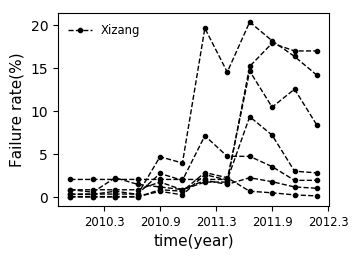

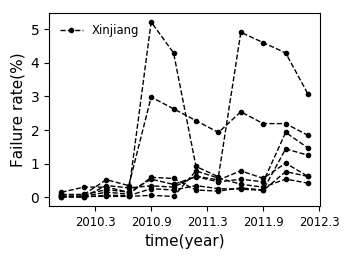

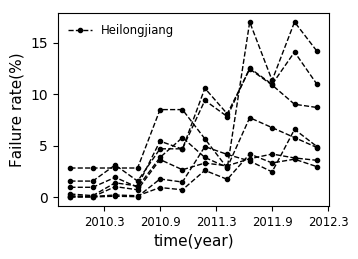

In [2]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 1 # 控制图形显示存储
plt.style.use('default')
elec_data = pd.read_csv('XZnozero_12.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values
# print(companyABC)
# print(companiesABC)
# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 1, size=[len(elec_data.Year.values), 3])

# #特征因素分析
elec_tem = elec_data.Tem.values # 观测温度值x2，温度不加噪声
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 0]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 1] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 2] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)

# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
# data_cs_year = np.ma.masked_values(elec_year, value=-999)
# print(data_cs_year)

elec_Pca = np.vstack((elec_tem1, elec_hPa1, elec_RH1, elec_Lux1)).T   # 特征数据合并为一个数组
# np.savetxt('XZ_nomean.csv', elec_Pca2, delimiter = ',')
# =============================================================================================
# # PCA特征降维，减少相关性，有两种方法，一种是自带函数，一种是网上程序，下面注释为网上程序
# x, z= pcaa(elec_Pca);  XX = np.array(x); ZZ = np.array(z)
# 将温度等4个特征降维变成2个特征，贡献率为99%以上，满足信息要求; 转换后的特征经过模型后能否还原
# =============================================================================================
# #白化，使得每个特征具有相同的方差，减少数据相关性，n_components：控制特征量个数
pca = PCA(n_components=2)
pca.fit(elec_Pca)
# 将数据X转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用transform方法来降维。
elec_Pca1 = pca.transform(elec_Pca)
elec_Pca1 = np.array(elec_Pca1)

elec_Pca_char1 = elec_Pca1[:, 0] # 降维特征1
elec_Pca_char2 = elec_Pca1[:, 1] # 降维特征2
print('\n')

# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
# data_fault = np.ma.masked_values(elec_data.Fault.values, value=-999)
# print(data_fault)
# elec_faults = 1000*(data_fault / elec_data.Nums.values)  # 数组形式,计算故障率大小
elec_faults = 1000*(elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
# elec_faults = np.ma.masked_values(elec_faults, value=1000)
# print(elec_faults[:84])
# elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)
# elec_faults[1] = 30 
# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*12:(i+1)*12] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*12:(i+1)*12] for i in np.arange(21)])
elec_char1 = np.array([elec_Pca_char1[i*12:(i+1)*12] for i in np.arange(21)])
elec_char2 = np.array([elec_Pca_char2[i*12:(i+1)*12] for i in np.arange(21)])
companyABC2 = np.array([companyABC[i*12:(i+1)*12] for i in np.arange(21)])
# elec_faults2 = np.ma.masked_values(elec_faults2, value=1000)
# print(elec_faults2)
Plot_raw(elec_year2, elec_faults2, Savefig)
# 共享变量设置
# xs_char1 = shared(np.asarray(elec_Pca_char1))
# xs_char2 = shared(np.asarray(elec_Pca_char2))

# ys_faults = shared(np.asarray(elec_faults))
# xs_year = shared(np.asarray(data_cs_year))
# Num_shared = shared(np.asarray(companyABC))

def logit(x):
    return 1/(1+np.exp(-x))
def Invlogit(x):
    return tt.exp(x)/(1+tt.exp(x))

In [3]:
import agate
import agatestats
table = agate.Table.from_csv('XZnozero_12.csv')

outliers = table.stdev_outliers('Fault', deviations=3, reject=True)
# print(outliers)
print(len(outliers.rows))
outliers1 = table.mad_outliers('Fault', deviations=3, reject=False)
# print(outliers1)
# print(len(outliers1.rows))
# outliers.to_csv('outline.csv')

9


In [4]:
# 采用三次B样条基函数进行拟合
x_zhou = 12
Num = len(elec_faults)
knots = np.linspace(1, x_zhou, Num)

Num_5 = 5 * len(elec_faults)
model_knots = np.linspace(1, x_zhou, Num_5)

# 能否将这里代码改为@as_op的形式，来让x的值得以调用
basis_funcs = sp.interpolate.BSpline(knots, np.eye(Num_5), k=3) # eye()生成对角矩阵
Bx = basis_funcs(elec_year)  # 表示在取值为x时的插值函数值
BxB = basis_funcs(elec_year[0:84])  # 表示在取值为x时的插值函数值
BxC = basis_funcs(elec_year[0:84])  # 表示在取值为x时的插值函数值
# shared:符号变量（symbolic variable），a之所以叫shared variable是因为a的赋值在不同的函数中都是一致的搜索，即a是被shared的
Bx_ = shared(Bx)
Bx_B = shared(BxB)
Bx_C = shared(BxC)

In [5]:
change,changeB,changeC = np.array([0 for i in np.arange(len(elec_year))]),\
                            np.array([0 for i in np.arange(len(elec_year))]),\
                                np.array([0 for i in np.arange(len(elec_year))])
# change = np.array(company)
change[:84] = 1
changeB[84:168] = 1
changeC[168:] = 1
print(change)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [6]:
# 建模，模型
with pm.Model() as model_1:
    # define priors
#     beta1 = pm.GaussianRandomWalk('beta1', sd=1, shape=companiesABC)
    alpha = pm.HalfCauchy('alpha', 10.)
#     alpha = pm.HalfCauchy('alpha', 10.)
#     alpha = pm.HalfCauchy('alpha', 10.)
    
    σ_a = pm.HalfCauchy('σ_a', 5.)
    a0 = pm.Normal('a0', 0., 20.)
    Δ_a = pm.Normal('Δ_a', 0., 10., shape = (Num_5))
    δ = pm.Normal('δ', 0, sd=10) # 若模型收敛差则δ改用这个语句
    
#     σ_aB = pm.HalfCauchy('σ_aB', 5.)
#     a0B = pm.Normal('a0B', 0., 20.)
#     Δ_aB = pm.Normal('Δ_aB', 0., 10., shape = (Num_5))
    δB = pm.Normal('δB', 0, sd=10) # 若模型收敛差则δ改用这个语句
    
#     σ_aC = pm.HalfCauchy('σ_aC', 5.)
#     a0C = pm.Normal('a0C', 0., 20.)
#     Δ_aC = pm.Normal('Δ_aC', 0., 10., shape = (Num_5))
    δC = pm.Normal('δC', 0, sd=10) # 若模型收敛差则δ改用这个语句
    
#     beta = pm.Normal('beta', 0, sd=100)
#     beta1 = pm.Normal('beta1', 0, sd=100)
    
    theta1 = pm.Deterministic('theta1', a0 + (σ_a * Δ_a).cumsum())
#     theta = pm.Deterministic('theta',   tt.exp(Bx_.dot(theta1)   + δ  + beta*elec_tem1[0:84]+ beta1*elec_RH1[0:84]))
    theta = pm.Deterministic('theta',  tt.exp(change*(Bx_.dot(theta1)+δ) +  \
                                                    changeB*(Bx_.dot(theta1) +δB) +  \
                                                        changeC*(Bx_.dot(theta1) +δC)))
    
#     theta1B = pm.Deterministic('theta1B', a0B + (σ_aB * Δ_aB).cumsum())
#     thetaB = pm.Deterministic('thetaB', tt.exp(Bx_B.dot(theta1B) + δB))
    
#     theta1C = pm.Deterministic('theta1C', a0C + (σ_aC * Δ_aC).cumsum())
#     thetaC = pm.Deterministic('thetaC', tt.exp(Bx_C.dot(theta1C) + δC))
    
    Observed = pm.Weibull('Observed',alpha=alpha, beta =theta, observed=elec_faults)  # 观测值
#     ObservedB = pm.Weibull('ObservedB',alpha=alpha, beta =thetaB, observed=elec_faults[84:168])  # 观测值
#     ObservedC = pm.Weibull('ObservedC',alpha=alpha, beta =thetaC, observed=elec_faults[168:])  # 观测值
#     step1 = pm.Slice([Δ_a])
    start = pm.find_MAP()
    trace_1 = pm.sample(1000,start=start,  njobs=1)

logp = -4,466.7, ||grad|| = 0.21: 100%|███████████████████████████████████████████████| 97/97 [00:00<00:00, 278.40it/s]
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\sampling.py:310: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\sampling.py:310: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\sampling.py:310: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\sampling.py:310: Deprecation

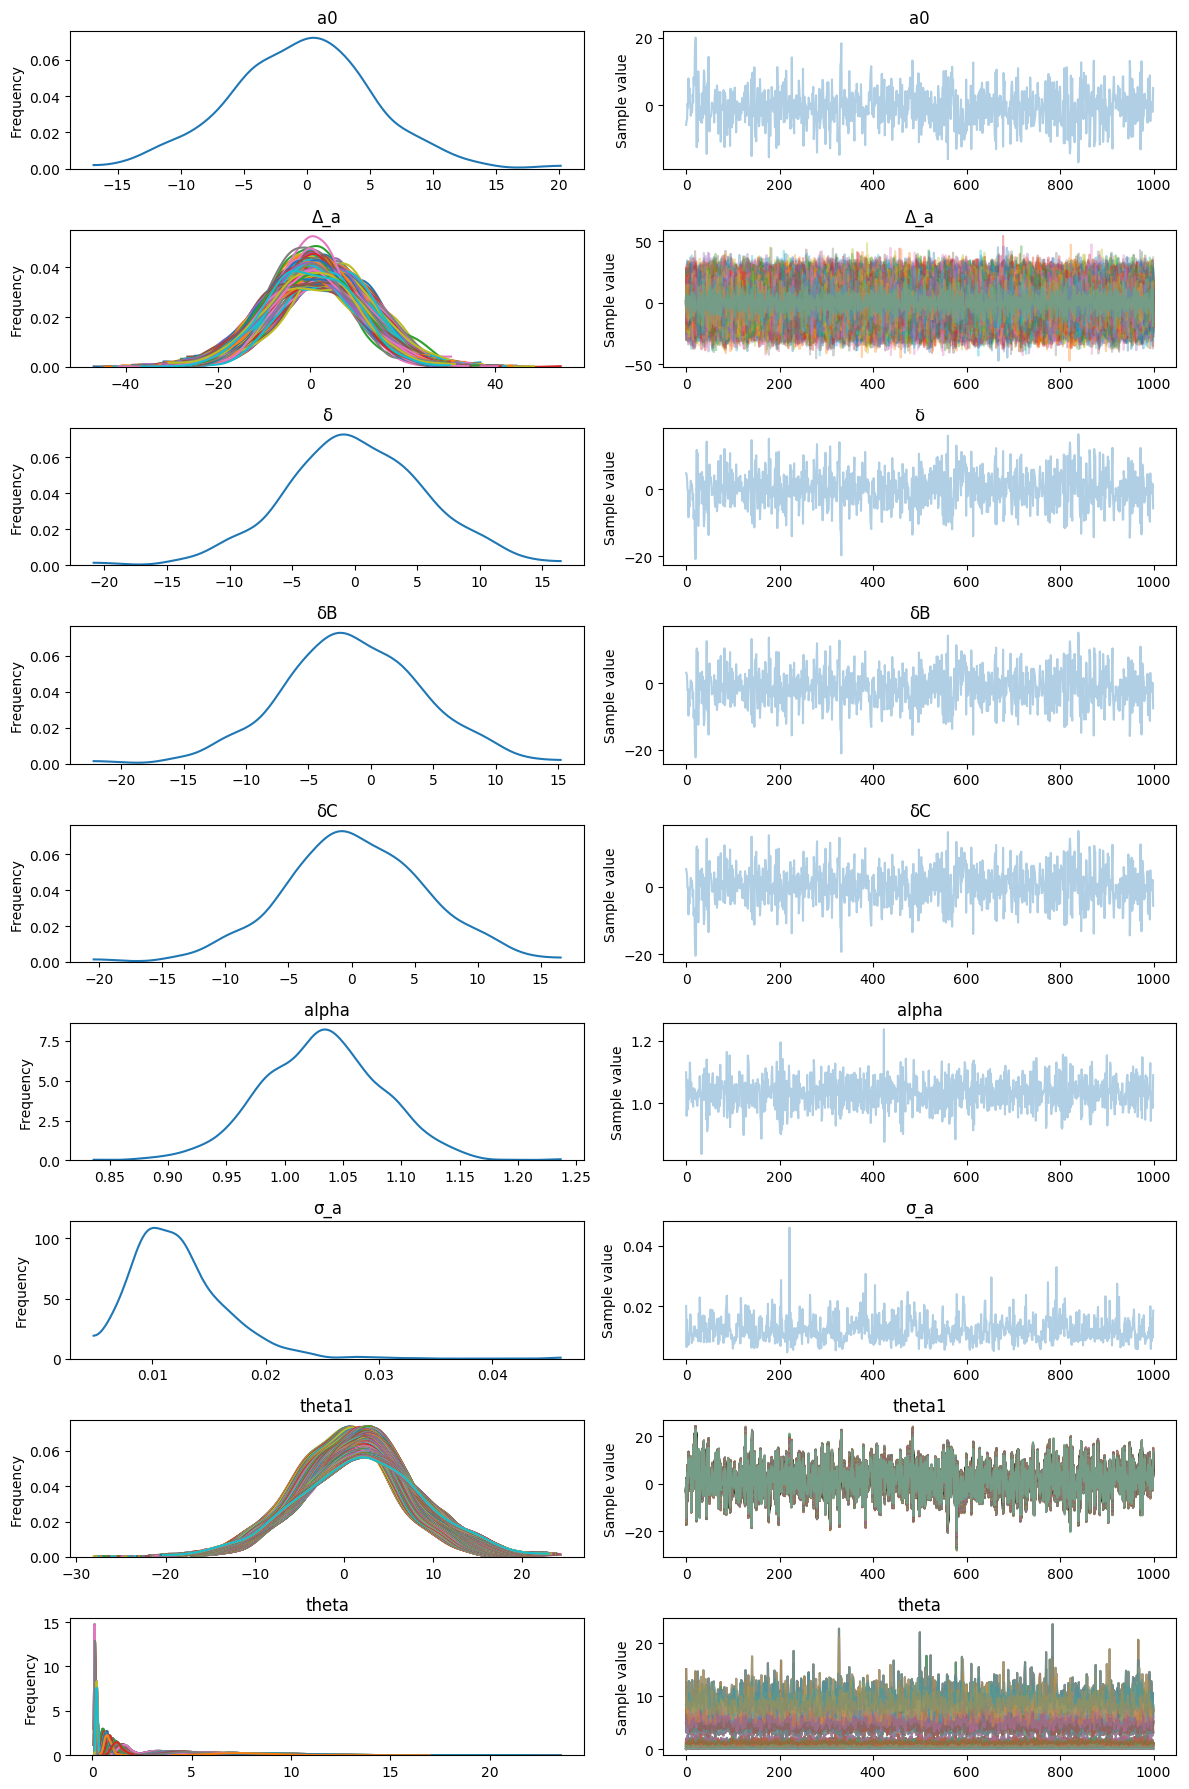

In [7]:
pm.traceplot(trace_1)
plt.show()


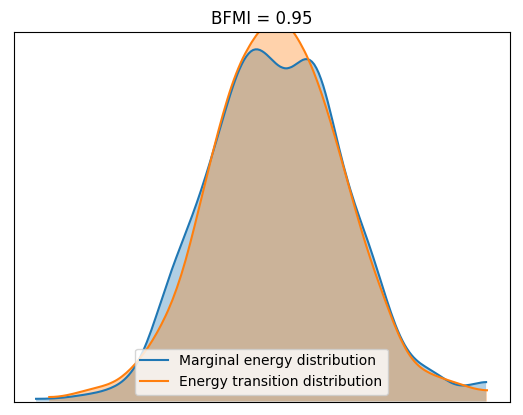

In [8]:
ax = pm.energyplot(trace_1)
bfmi = pm.bfmi(trace_1)
ax.set_title(f"BFMI = {bfmi:.2f}");
plt.show()

theta__0     0.595674
theta__1     0.654602
theta__2     1.078496
theta__3     1.066321
theta__4     3.627997
theta__5     3.881920
theta__6     4.728069
theta__7     4.252389
theta__8     7.497107
theta__9     7.305485
theta__10    7.900598
theta__11    6.556689
Name: mean, dtype: float64


  0%|                                                                                 | 1/1000 [00:00<09:36,  1.73it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

  9%|██████▉                                                                        | 88/1000 [00:00<00:08, 113.10it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 339.58it/s]


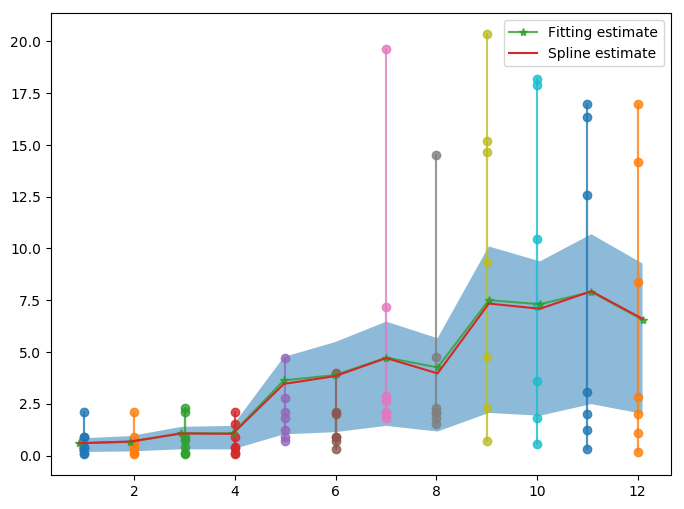

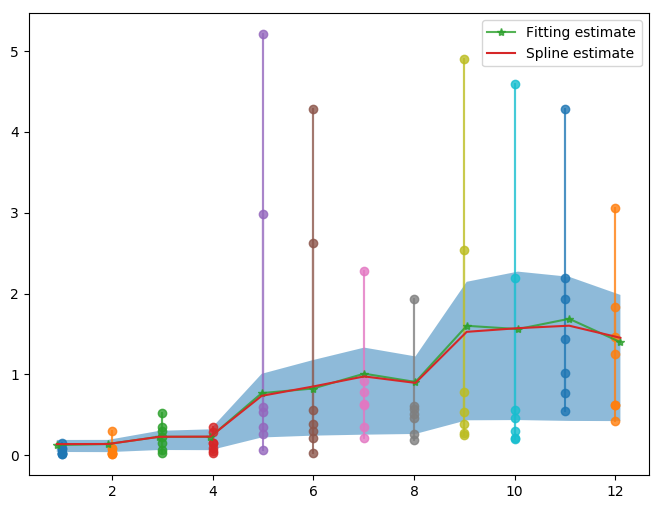

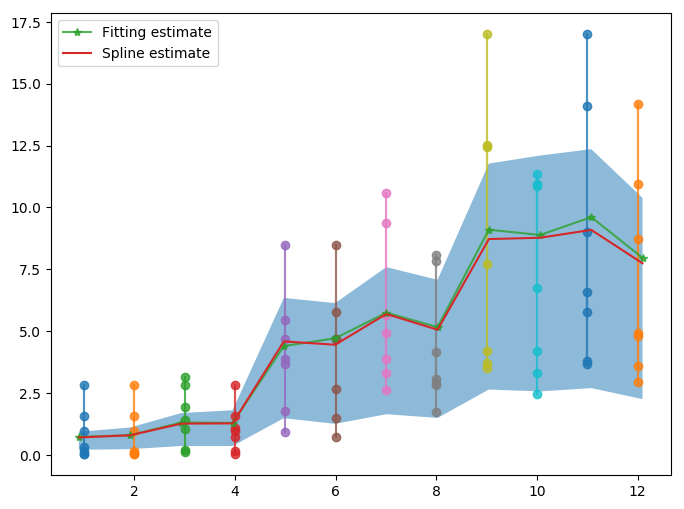

In [9]:
# 后验分析
varnames2 = ['theta']
tmp = pm.df_summary(trace_1, varnames2)
betaMAP = tmp['mean'][np.arange(12)]
betaMAPB = tmp['mean'][84:96]
betaMAPC = tmp['mean'][168:180]
print(betaMAP)

with model_1:
    pp_trace = pm.sample_ppc(trace_1, 1000)
ip=0
fig, ax = plt.subplots(figsize=(8, 6))
x_plot = np.linspace(0.9, 12.1, 12)
low, high = np.percentile(pp_trace['Observed'], [25, 75], axis=0)
 
xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
yp = elec_faults2[ip*7:(ip+1)*7, :]
ax.plot(xp, yp, marker='o', alpha=.8)
ax.plot(x_plot, betaMAP[:], marker='*', alpha=.8, label="Fitting estimate")
ax.fill_between(x_plot, low[:12], high[:12],  alpha=0.5)
ax.plot(x_plot, pp_trace['Observed'].mean(axis=0)[:12], label="Spline estimate")
# ax.set_xlim(0, 1)
ax.legend()
plt.show()


# varnames2 = ['thetaB']
# tmpB = pm.df_summary(trace_1, varnames2)
# betaMAPB = tmpB['mean'][np.arange(12)]
ip=1
fig, ax = plt.subplots(figsize=(8, 6))
x_plot = np.linspace(0.9, 12.1, 12)
# low, high = np.percentile(pp_trace['ObservedB'], [5, 95], axis=0)

xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
yp = elec_faults2[ip*7:(ip+1)*7, :]
ax.plot(xp, yp, marker='o', alpha=.8)
ax.plot(x_plot, betaMAPB[:], marker='*', alpha=.8, label="Fitting estimate")
ax.fill_between(x_plot, low[84:96], high[84:96],  alpha=0.5)
ax.plot(x_plot, pp_trace['Observed'].mean(axis=0)[84:96], label="Spline estimate")
# ax.set_xlim(0, 1)
ax.legend()
plt.show()


# varnames2 = ['thetaC']
# tmpC = pm.df_summary(trace_1, varnames2)
# betaMAPC = tmpC['mean'][np.arange(12)]
ip=2
fig, ax = plt.subplots(figsize=(8, 6))
x_plot = np.linspace(0.9, 12.1, 12)
# low, high = np.percentile(pp_trace['ObservedC'], [5, 95], axis=0)

xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
yp = elec_faults2[ip*7:(ip+1)*7, :]
ax.plot(xp, yp, marker='o', alpha=.8)
ax.plot(x_plot, betaMAPC[:], marker='*', alpha=.8, label="Fitting estimate")
ax.fill_between(x_plot, low[168:180], high[168:180],  alpha=0.5)
ax.plot(x_plot, pp_trace['Observed'].mean(axis=0)[168:180], label="Spline estimate")
# ax.set_xlim(0, 1)
ax.legend()
plt.show()

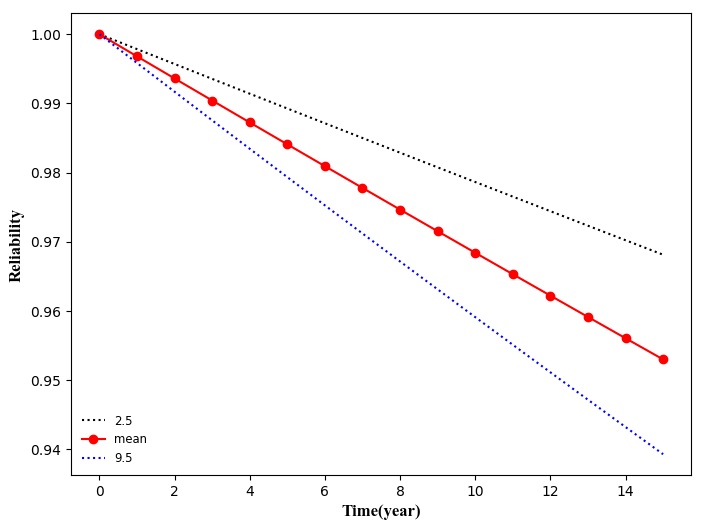

In [32]:
font1 ={'family': 'times new roman', 'weight':'light', 'size': 12}  
chain1 = trace_1
# 可靠度计算，beta_mu要除以100还原
post_alpha1 = np.mean(chain1['alpha'])
# post_beta_mu1 = (np.mean(chain1['theta'])/1000+np.mean(chain1['thetaB'])/1000+np.mean(chain1['thetaC'])/1000)/3
post_beta_mu1 = (np.mean(chain1['theta'])/1000)
# varnames1 = ['alpha', 'theta', 'thetaB', 'thetaC']
varnames1 = ['alpha', 'theta']
aaa1 = pm.df_summary(chain1, varnames1)
bbb1 = pd.DataFrame(aaa1)

hpdd2_5 = bbb1['hpd_2.5']
hpdd97_5 = bbb1['hpd_97.5']
hpd2_5_alpha = hpdd2_5[:1].mean()
hpd97_5_alpha = hpdd97_5[:1].mean()
hpd25_beta_mu = hpdd2_5[1:].mean()/1000
hpd975_beta_mu = hpdd97_5[1:].mean()/1000

# 可靠度函数：这里为故障度函数
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)
t = np.arange(0, 16, 1)
R1 = np.exp(-((t/post_beta_mu1)**post_alpha1))
R2 = np.exp(-((t/hpd25_beta_mu)**hpd2_5_alpha))
R3 = np.exp(-((t/hpd975_beta_mu)**hpd97_5_alpha))
# plt.plot(t, R2, 'k:', t, R1, 'bo-', t, R3, 'r:')
# 需要进行转换以进行可靠度分析，依据书71页的表达式，可反推出可靠度函数
R11 = np.exp(-((t/post_alpha1)*post_beta_mu1))
R22 = np.exp(-((t/hpd2_5_alpha)*hpd25_beta_mu))
R33 = np.exp(-((t/hpd97_5_alpha)*hpd975_beta_mu))
plt.plot(t, R22, 'k:', t, R11, 'ro-', t, R33, 'b:')
# ax.set_xticklabels(['2016', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'], fontsize='small')
ax.set_xlabel("Time(year)", fontdict=font1)
plt.ylabel("Reliability", fontdict=font1)
# plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')
ax.legend(['2.5','mean','9.5'], loc='lower left',frameon=False, fontsize='small')

# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\EI\\Picture\\Reliability.png', dpi = 200, bbox_inches='tight')
plt.show()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

 20%|███████████████▉                                                              | 204/1000 [00:00<00:01, 403.69it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 79%|█████████████████████████████████████████████████████████████▋                | 791/1000 [00:01<00:00, 409.60it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

 88%|████████████████████████████████████████████████████████████████████▍         | 877/1000 [00:02<00:00, 411.03it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

[0. 1. 1. 1. 3. 3. 4. 3. 6. 6. 6. 5.]


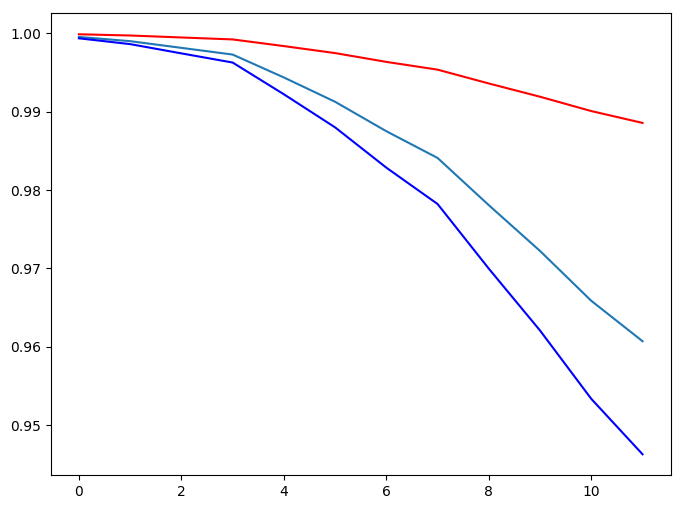

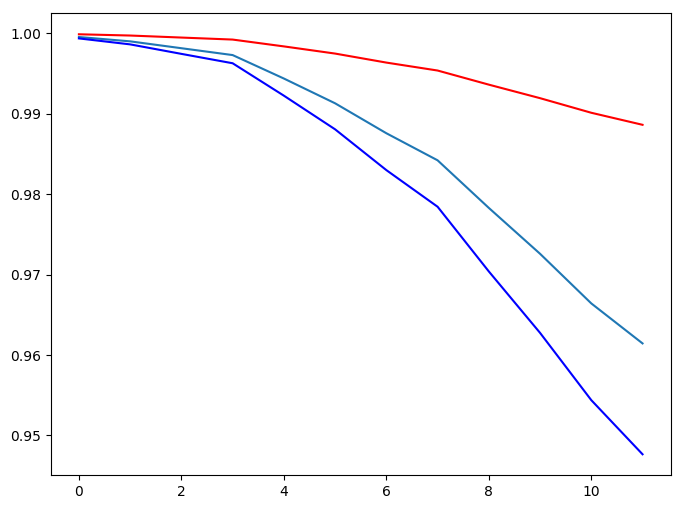

In [45]:
with model_1:
    pp_trace2 = pm.sample_ppc(trace_1, 1000)
post_pred2 = pp_trace2['Observed']
# print(post_pred2)
yipred_mean0 = post_pred2.mean(axis=0) #256

Mean_pred1 = np.array([yipred_mean0[i*12:(i+1)*12] for i in np.arange(21)])
Mean_pred2 = Mean_pred1.mean(axis=0)
print(Mean_pred2)

low, high = np.percentile(pp_trace2['Observed'], [25, 75], axis=0)
Mean_low1 = np.array([low[i*12:(i+1)*12] for i in np.arange(21)])
Mean_low2 = Mean_low1.mean(axis=0)
Mean_high1 = np.array([high[i*12:(i+1)*12] for i in np.arange(21)])
Mean_high2 = Mean_high1.mean(axis=0)

Mean12 = Mean_pred2[:12]/1000
Meanlow3 = Mean_low2[:12]/1000
Meanhigh3 = Mean_high2[:12]/1000
AAA = []
BBB = []
CCC = []
for i in range(len(Mean12)):
    AAA.append(1-Mean12[:(i+1)].sum())
    BBB.append(1-Meanlow3[:(i+1)].sum())
    CCC.append(1-Meanhigh3[:(i+1)].sum())
# YAAA= 1 - AAA
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(AAA)
ax.plot(BBB, 'r')
ax.plot(CCC, 'b')
plt.show()



AAA = []
BBB = []
CCC = []
for i in range(len(Mean12)):
    AAA.append(np.exp(-Mean12[:(i+1)].sum()))
    BBB.append(np.exp(-Meanlow3[:(i+1)].sum()))
    CCC.append(np.exp(-Meanhigh3[:(i+1)].sum()))
# YAAA= 1 - AAA
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(AAA)
ax.plot(BBB, 'r')
ax.plot(CCC, 'b')
plt.show()

